In [1]:
import time
import torch
from torch import nn
import torch.backends.cudnn as cudnn
from models import SRResNet
from datasets import SRDataset
from dataset import LowDataset
from utils import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data parameters
data_folder = 'data'
crop_size = 96  # crop size of target HR images
scaling_factor = 4  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor

# Model parameters
large_kernel_size = 9  # kernel size of the first and last convolutions which transform the inputs and outputs
small_kernel_size = 3  # kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
n_channels = 64  # number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
n_blocks = 16  # number of residual blocks

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 16  # batch size
start_epoch = 0  # start at this epoch
iterations = 1e6  # number of training iterations
workers = 4
print_freq = 100
lr = 1e-4
grad_clip = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cudnn.benchmark = True

cuda


In [3]:
def train(train_loader, valid_loader, model, criterion, optimizer, epoch):
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    tr_losses = AverageMeter()
    val_losses = AverageMeter()

    start = time.time()
    for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
        data_time.update(time.time() - start)

        lr_imgs = lr_imgs.to(device)  # (batch_size (N), 3, 24, 24), imagenet-normed
        hr_imgs = hr_imgs.to(device)  # (batch_size (N), 3, 96, 96), in [-1, 1]

        sr_imgs = model(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]
        loss = criterion(sr_imgs, hr_imgs)  # scalar

        optimizer.zero_grad()
        loss.backward()

        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)


        optimizer.step()
        tr_losses.update(loss.item(), lr_imgs.size(0))

        batch_time.update(time.time() - start)
        start = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]----'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})----'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})----'
                  'Loss {tr_loss.val:.4f} ({tr_loss.avg:.4f})'.format(epoch, i, len(train_loader), batch_time=batch_time,
                                                                    data_time=data_time, tr_loss=tr_losses))
            
    model.eval();
    with torch.no_grad():
        for i, (lr_imgs, hr_imgs) in enumerate(valid_loader):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            val_losses.update(loss.item(), lr_imgs.size(0))
    print('Epoch: [{0}] === Val Loss {val_loss.val:.4f} ({val_loss.avg:.4f})'.format(epoch, val_loss=val_losses))
    del lr_imgs, hr_imgs, sr_imgs


In [4]:
def main():
    global start_epoch, epoch, checkpoint

    if checkpoint is None:
        model = SRResNet(large_kernel_size=large_kernel_size, small_kernel_size=small_kernel_size,
                         n_channels=n_channels, n_blocks=n_blocks, scaling_factor=scaling_factor)
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    model = model.to(device)
    criterion = nn.MSELoss().to(device)

    """train_dataset = SRDataset(data_folder, split='train', crop_size=crop_size, scaling_factor=scaling_factor,
                              lr_img_type='imagenet-norm', hr_img_type='[-1, 1]')"""
    train_dataset = LowDataset('coco_tr', scaling_factor, 96)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
    valid_dataset = LowDataset('coco_val', scaling_factor, 96)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
    epochs = int(iterations // len(train_loader) + 1)

    for epoch in range(start_epoch, epochs):
        train(train_loader=train_loader, valid_loader=valid_loader, model=model, criterion=criterion, optimizer=optimizer, epoch=epoch)
        torch.save({'epoch': epoch, 'model': model, 'optimizer': optimizer}, 'checkpoint_srresnet.pth.tar')

In [5]:
if __name__ == '__main__':
    main()

Epoch: [0][0/1313]----Batch Time 2.047 (2.047)----Data Time 0.231 (0.231)----Loss 0.3092 (0.3092)
Epoch: [0][100/1313]----Batch Time 0.132 (0.151)----Data Time 0.000 (0.002)----Loss 0.0152 (0.0352)
Epoch: [0][200/1313]----Batch Time 0.132 (0.141)----Data Time 0.000 (0.001)----Loss 0.0114 (0.0240)
Epoch: [0][300/1313]----Batch Time 0.132 (0.138)----Data Time 0.000 (0.001)----Loss 0.0105 (0.0195)
Epoch: [0][400/1313]----Batch Time 0.195 (0.140)----Data Time 0.000 (0.001)----Loss 0.0080 (0.0170)
Epoch: [0][500/1313]----Batch Time 0.132 (0.148)----Data Time 0.000 (0.001)----Loss 0.0087 (0.0153)
Epoch: [0][600/1313]----Batch Time 0.196 (0.153)----Data Time 0.000 (0.001)----Loss 0.0077 (0.0142)
Epoch: [0][700/1313]----Batch Time 0.227 (0.158)----Data Time 0.000 (0.000)----Loss 0.0084 (0.0133)
Epoch: [0][800/1313]----Batch Time 0.211 (0.162)----Data Time 0.000 (0.000)----Loss 0.0103 (0.0127)
Epoch: [0][900/1313]----Batch Time 0.138 (0.165)----Data Time 0.000 (0.000)----Loss 0.0078 (0.0121)
Ep

KeyboardInterrupt: 

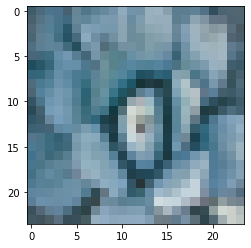

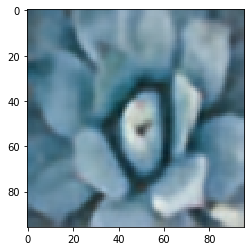

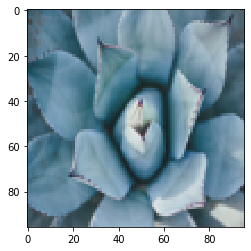

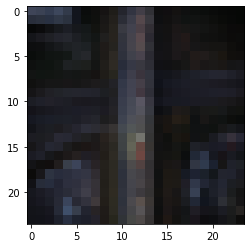

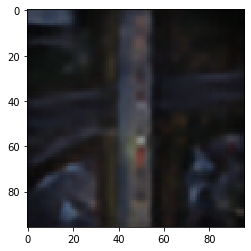

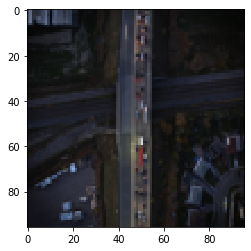

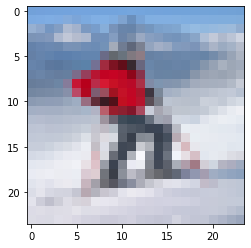

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


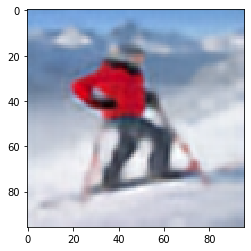

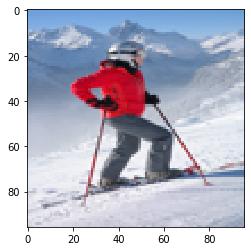

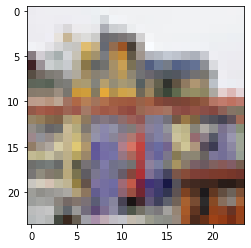

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


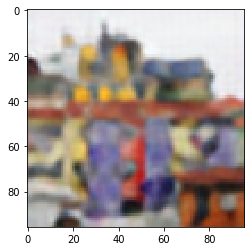

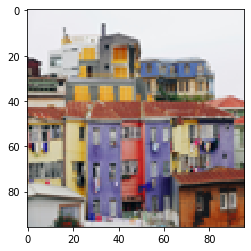

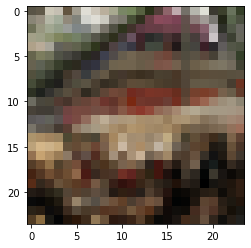

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


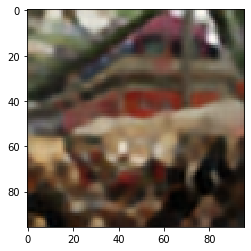

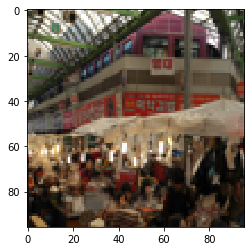

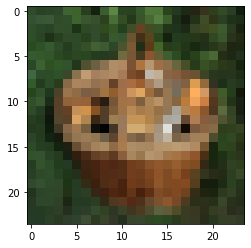

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


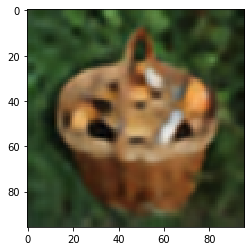

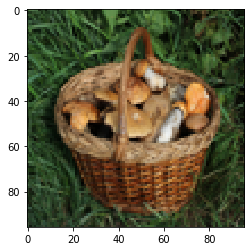

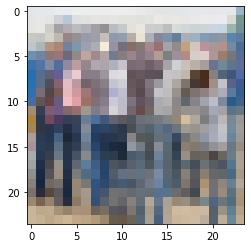

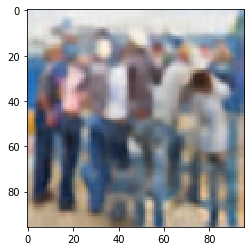

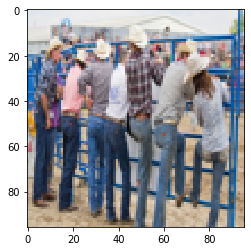

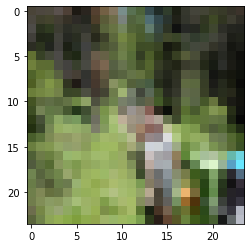

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


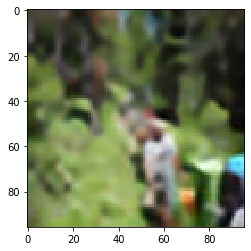

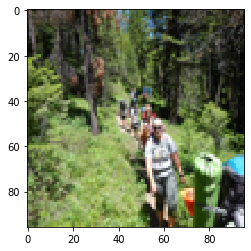

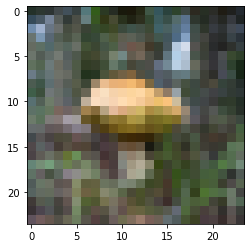

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


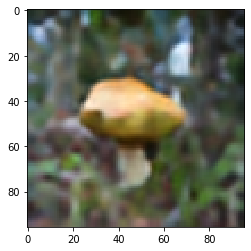

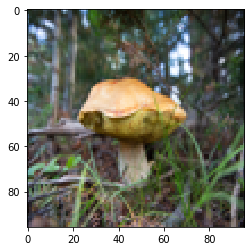

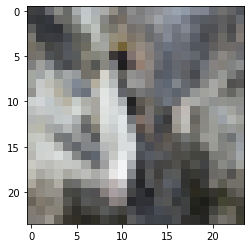

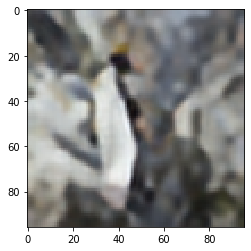

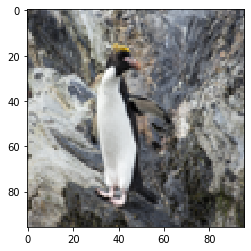

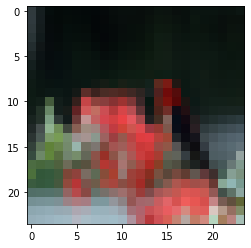

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


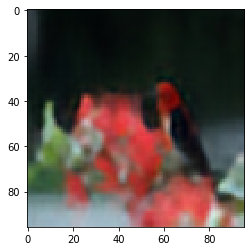

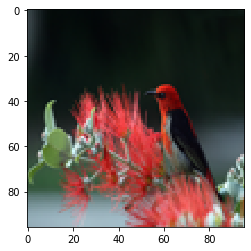

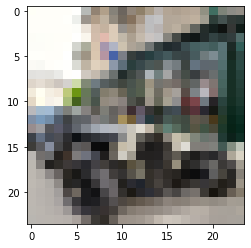

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


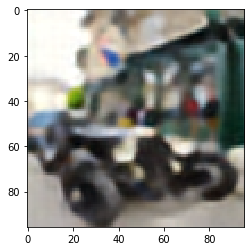

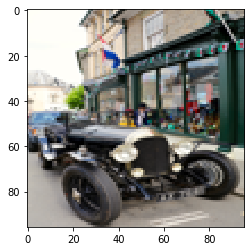

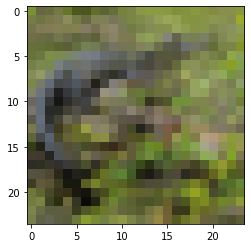

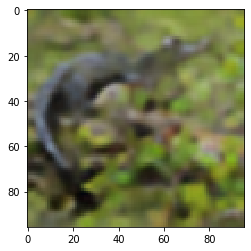

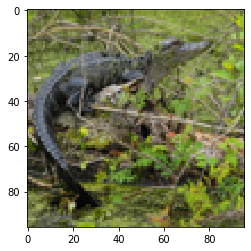

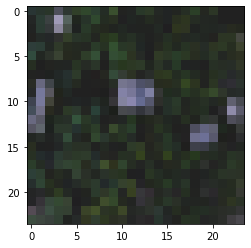

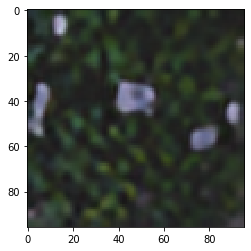

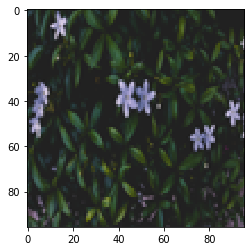

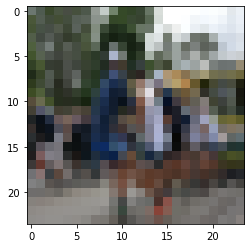

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


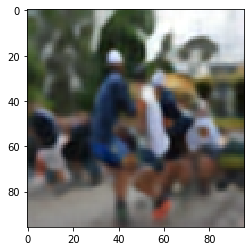

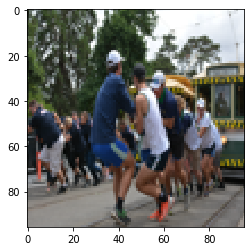

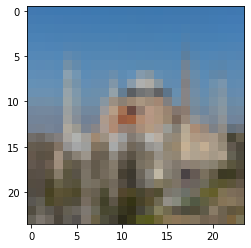

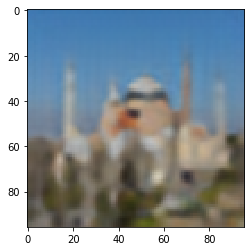

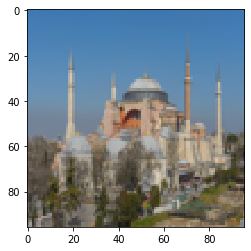

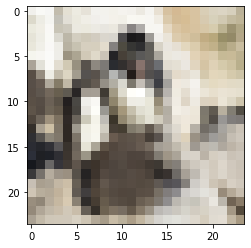

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


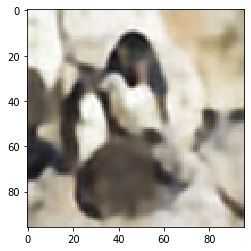

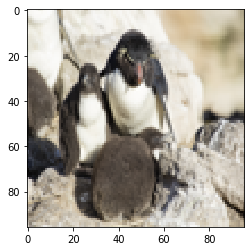

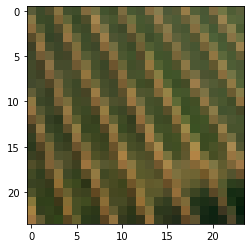

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


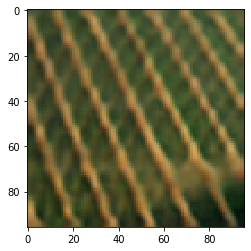

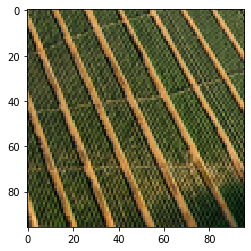

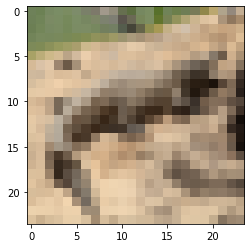

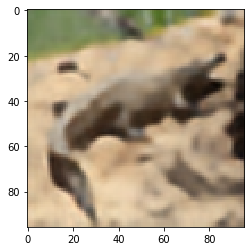

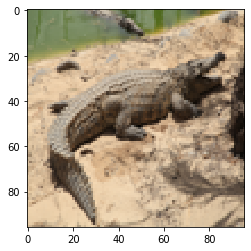

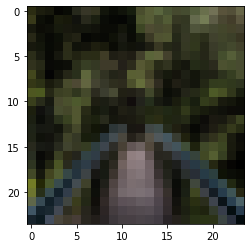

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


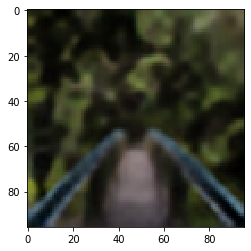

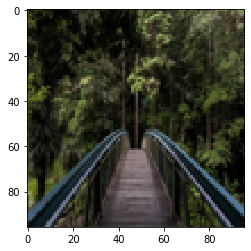

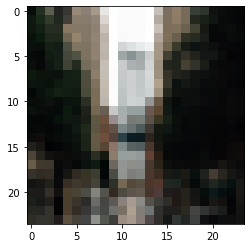

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


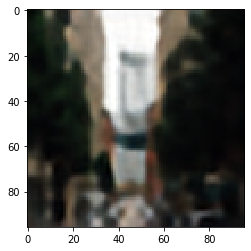

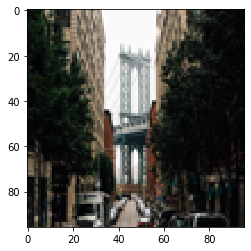

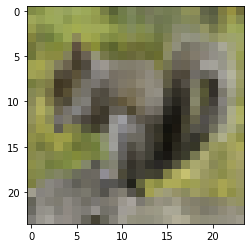

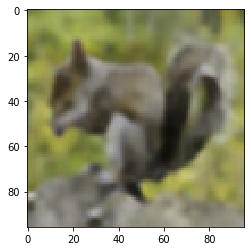

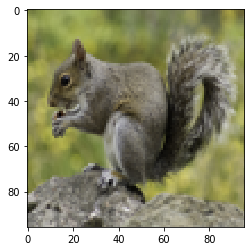

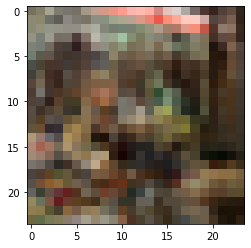

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


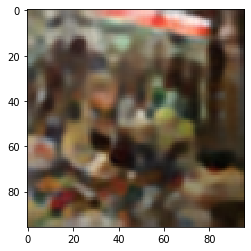

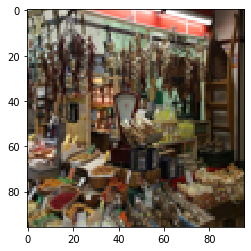

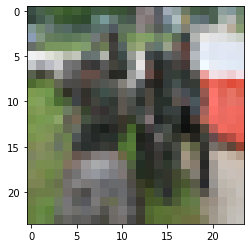

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


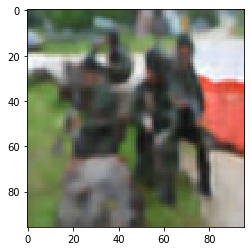

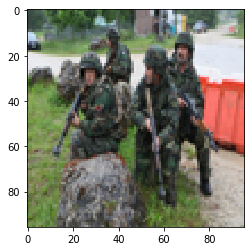

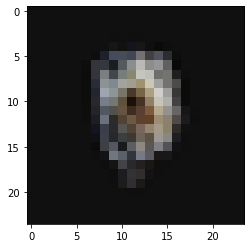

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


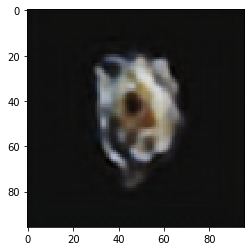

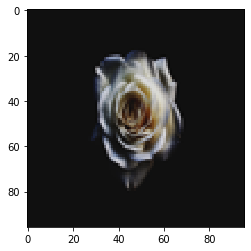

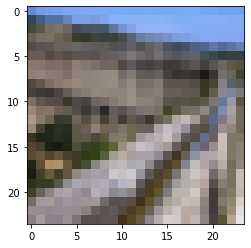

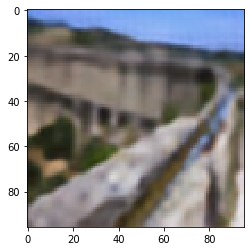

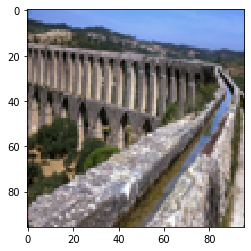

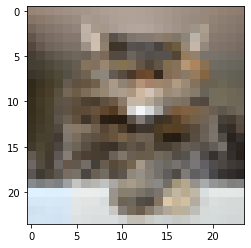

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


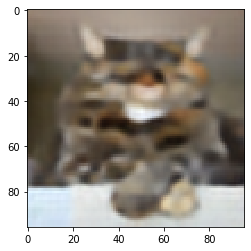

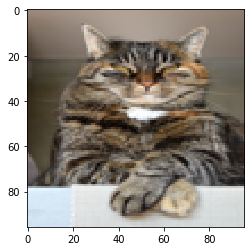

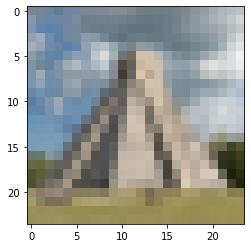

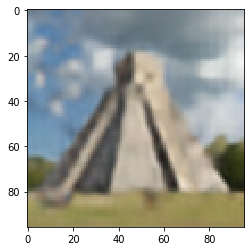

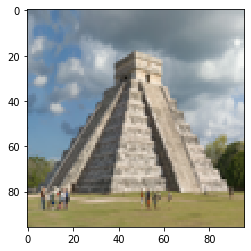

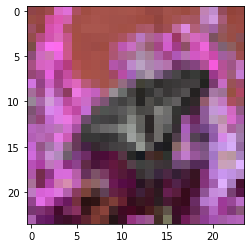

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


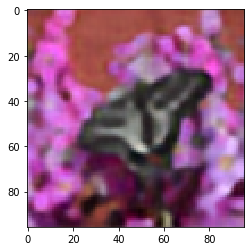

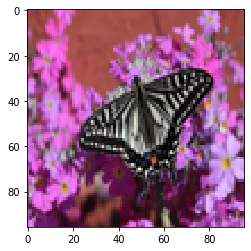

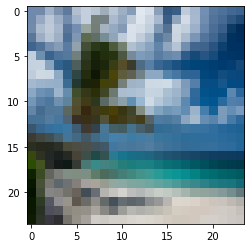

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


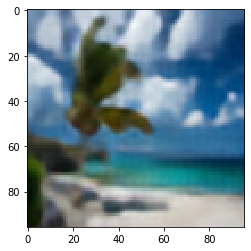

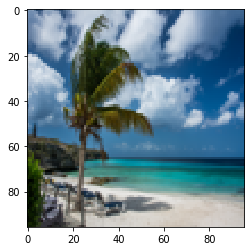

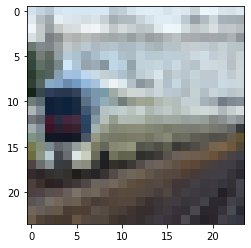

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


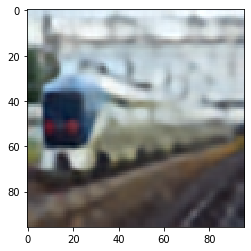

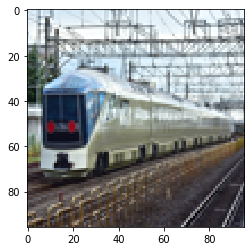

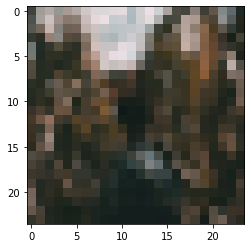

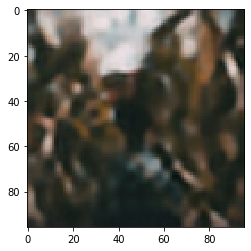

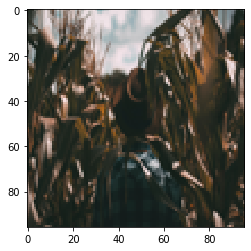

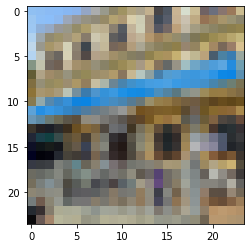

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


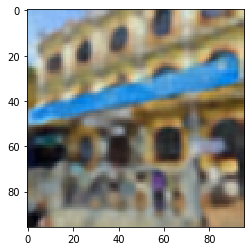

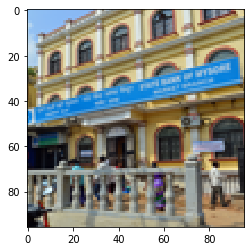

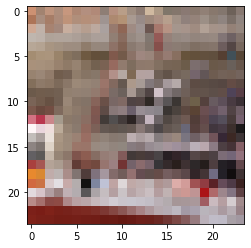

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


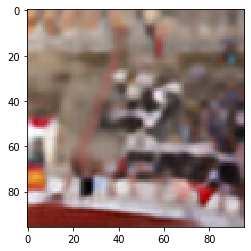

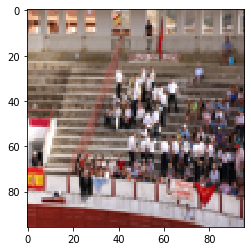

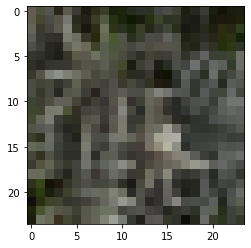

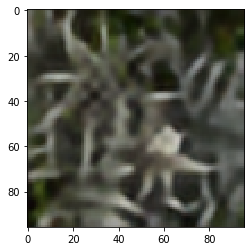

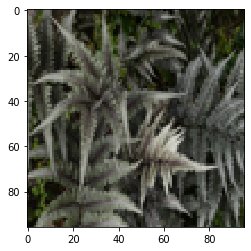

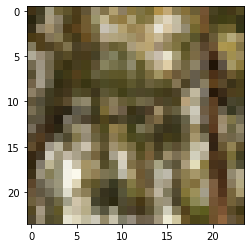

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


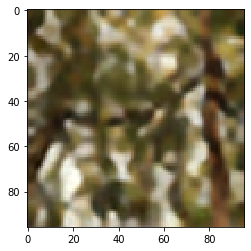

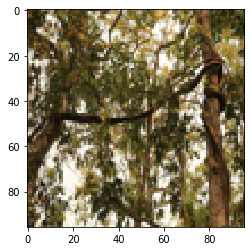

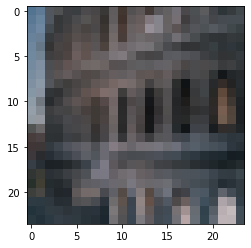

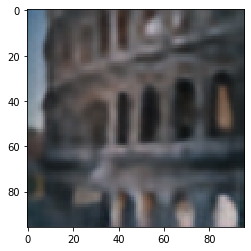

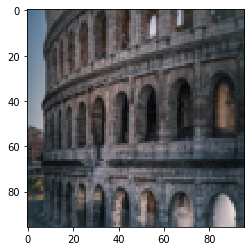

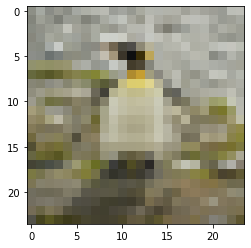

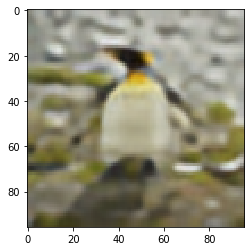

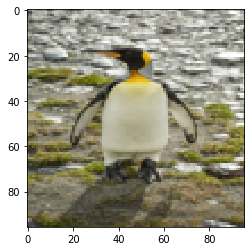

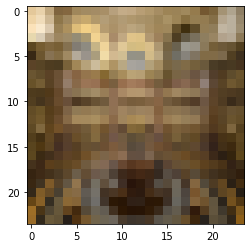

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


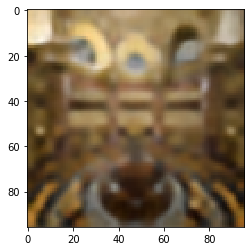

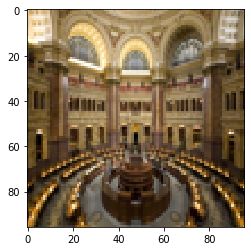

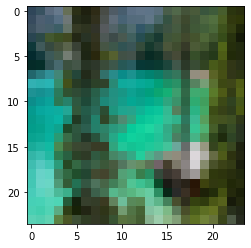

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


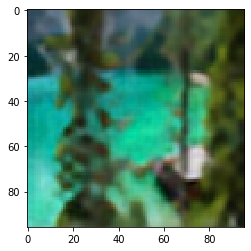

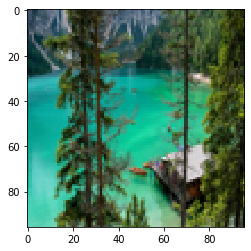

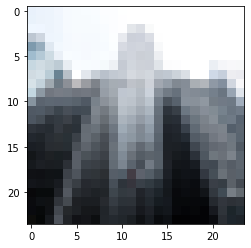

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


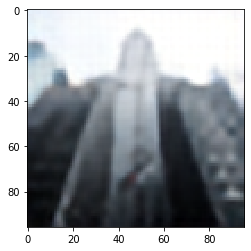

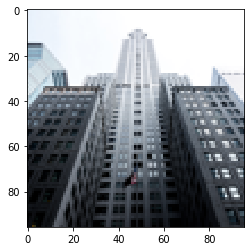

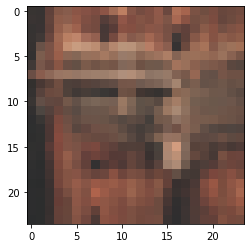

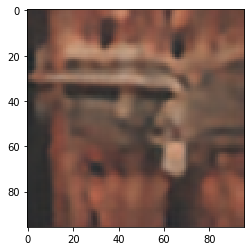

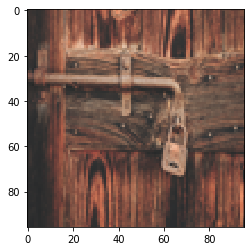

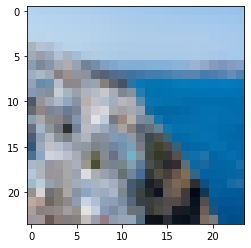

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


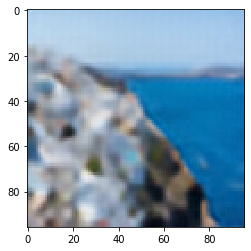

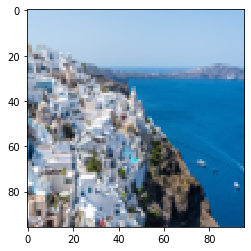

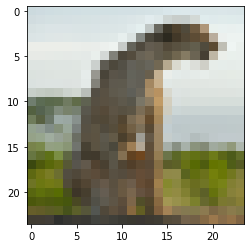

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


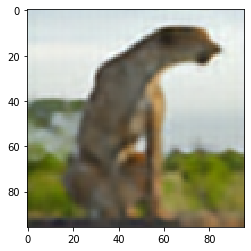

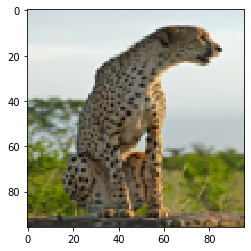

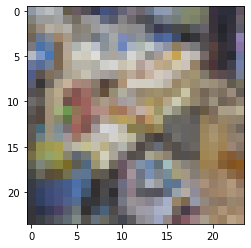

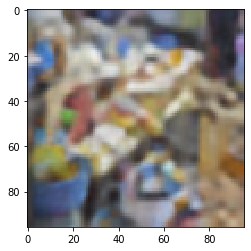

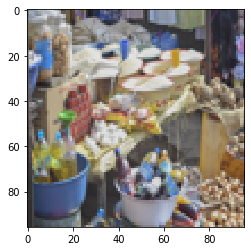

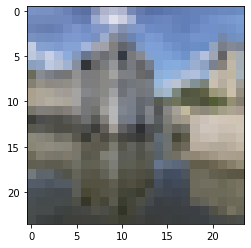

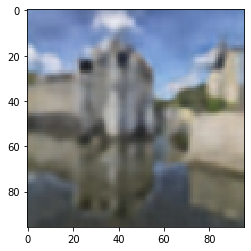

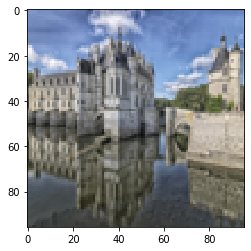

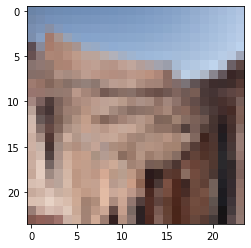

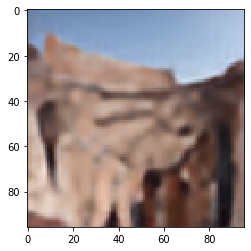

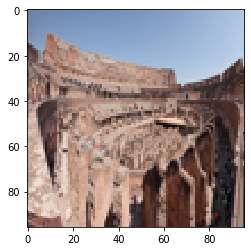

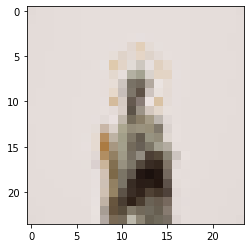

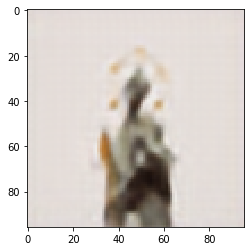

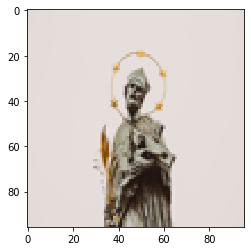

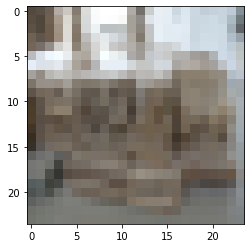

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


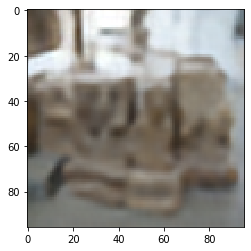

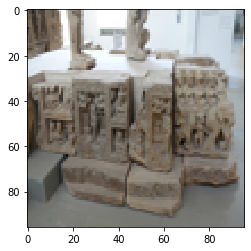

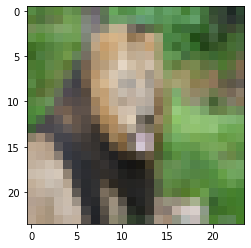

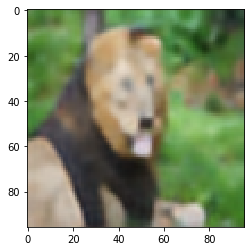

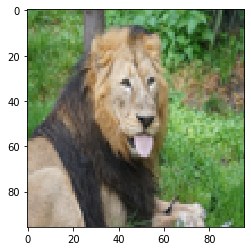

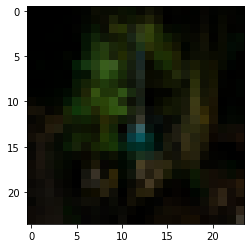

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


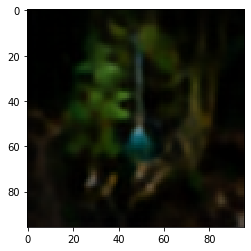

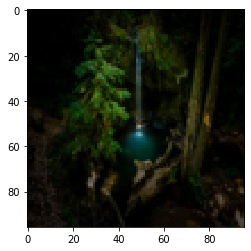

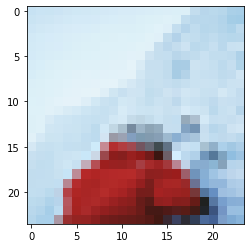

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


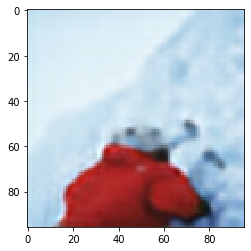

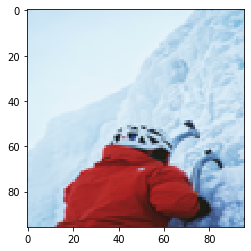

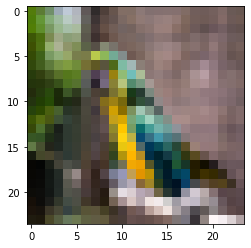

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


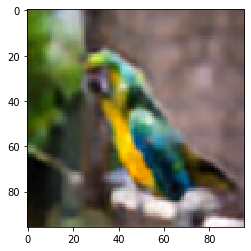

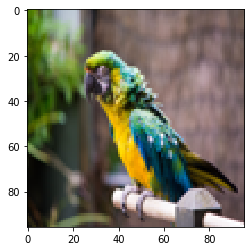

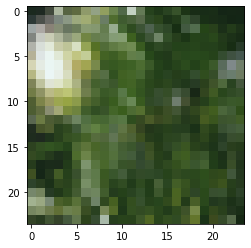

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


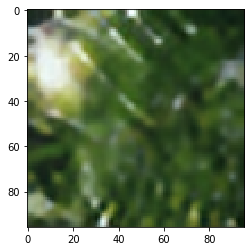

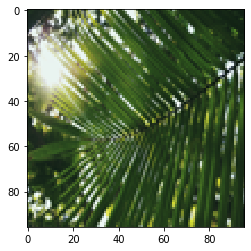

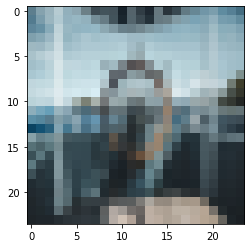

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


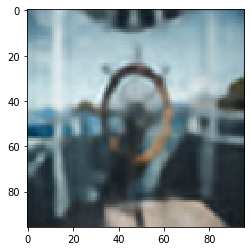

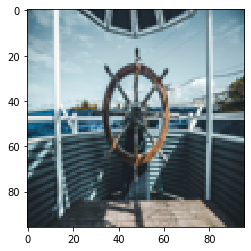

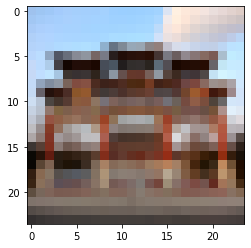

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


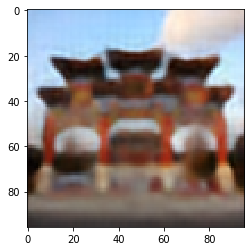

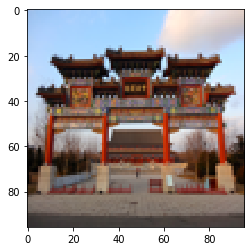

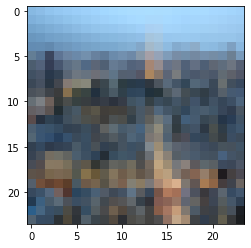

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


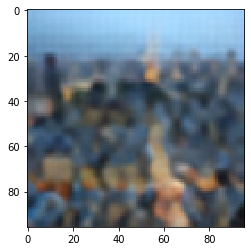

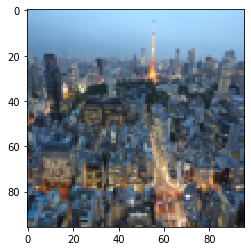

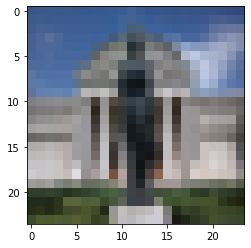

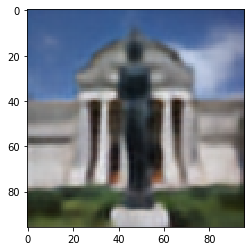

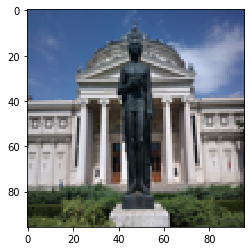

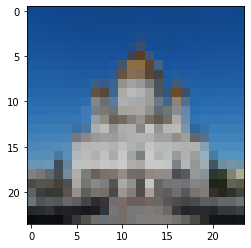

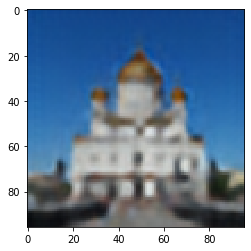

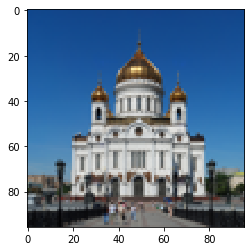

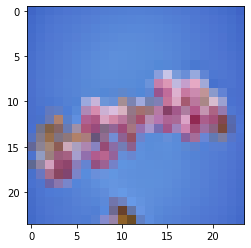

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


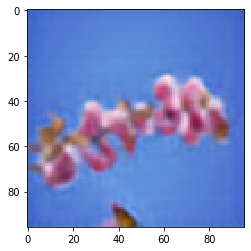

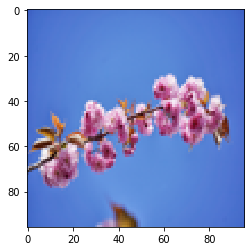

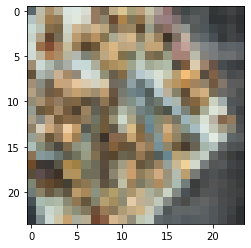

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


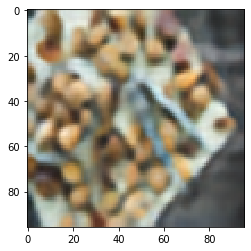

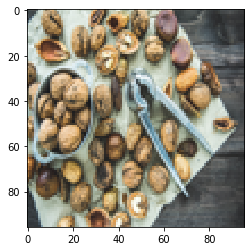

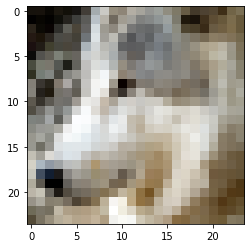

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


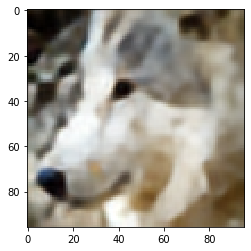

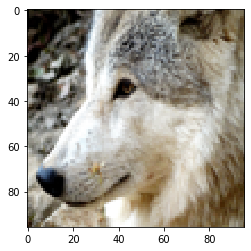

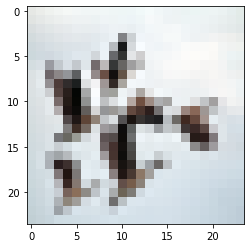

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


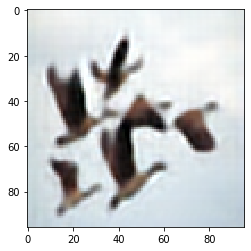

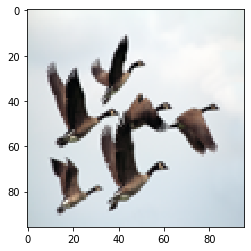

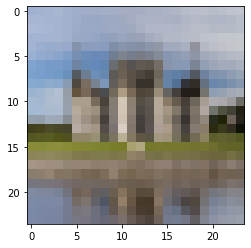

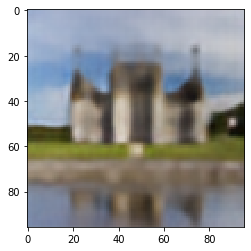

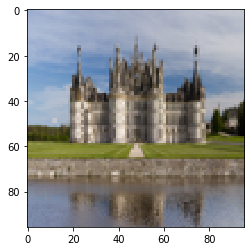

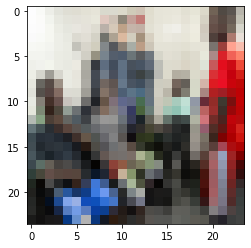

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


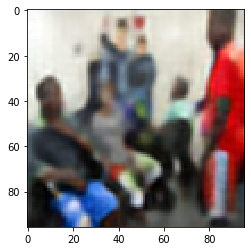

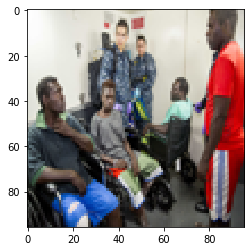

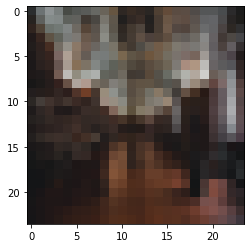

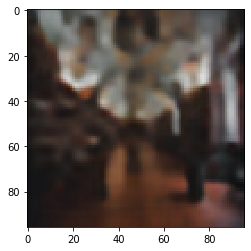

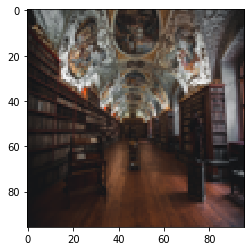

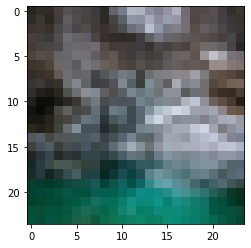

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


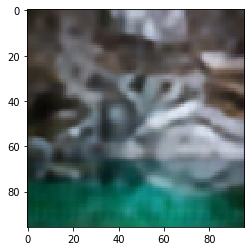

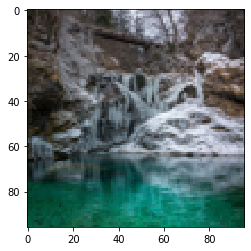

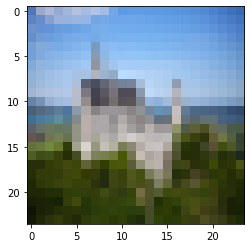

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


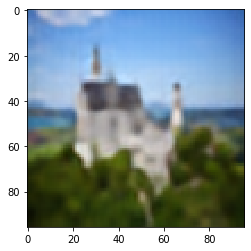

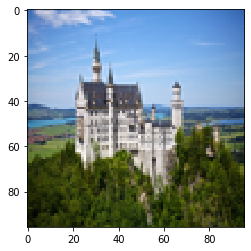

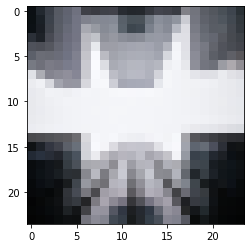

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


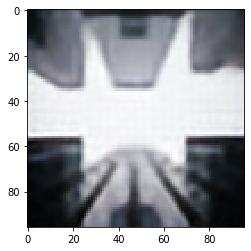

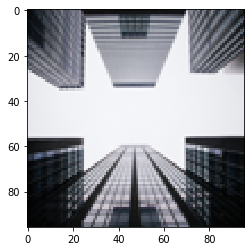

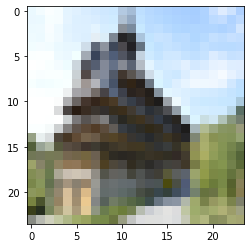

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


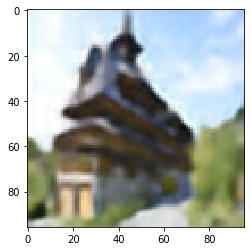

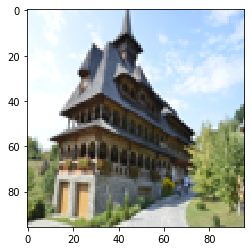

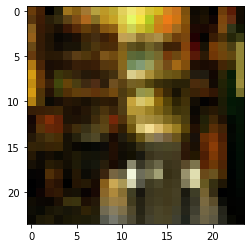

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


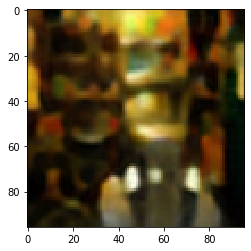

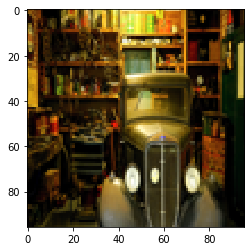

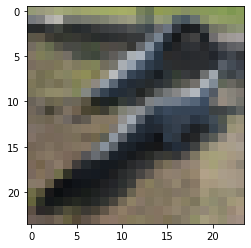

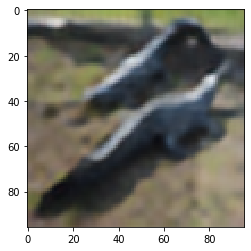

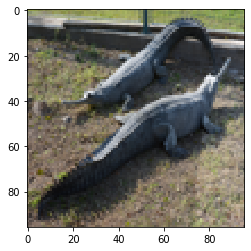

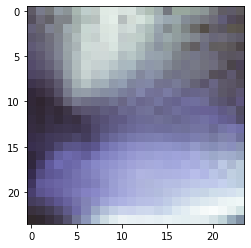

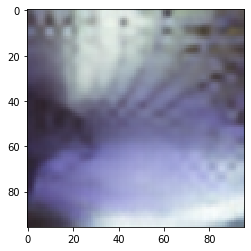

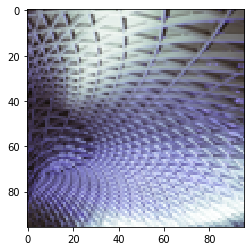

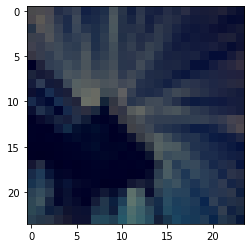

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


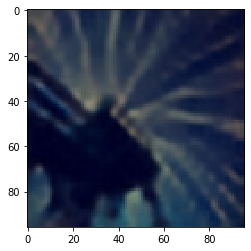

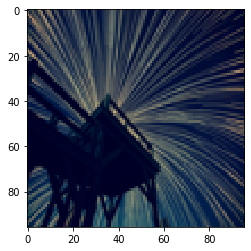

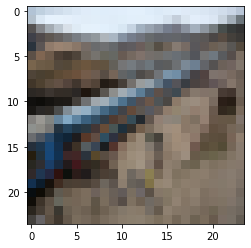

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


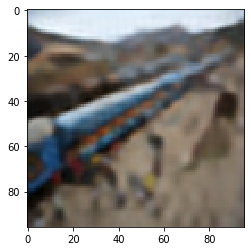

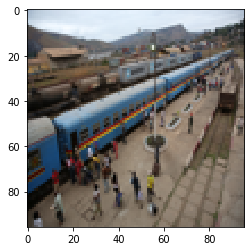

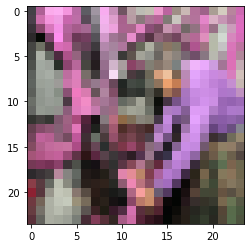

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


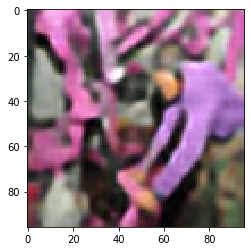

In [ ]:
checkpoint = torch.load('checkpoint_srresnet.pth.tar')
start_epoch = checkpoint['epoch'] + 1
model = checkpoint['model']
optimizer = checkpoint['optimizer']

model = model.to('cpu')
criterion = nn.MSELoss().to(device)

valid_dataset = LowDataset('valid')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=workers, pin_memory=True)

model.eval()
for i, (lr_imgs, hr_imgs) in enumerate(valid_loader):

    lr_imgs = lr_imgs.to('cpu')  # (batch_size (N), 3, 24, 24), imagenet-normed
    hr_imgs = hr_imgs.to('cpu')  # (batch_size (N), 3, 96, 96), in [-1, 1]

    sr_imgs = model(lr_imgs)  # (N, 3, 96, 96), in [-1, 1]
    plt.imshow(lr_imgs[0].detach().permute(1, 2, 0))
    plt.show()
    plt.imshow(sr_imgs[0].detach().permute(1, 2, 0))
    plt.show()
    plt.imshow(hr_imgs[0].detach().permute(1, 2, 0))
    plt.show()